In [1]:
import os
import sys
sys.path.append('..')

# metropolis

prior mean: 0, prior std: 1
Posterior mean: 0.35, Posterior std: 0.62


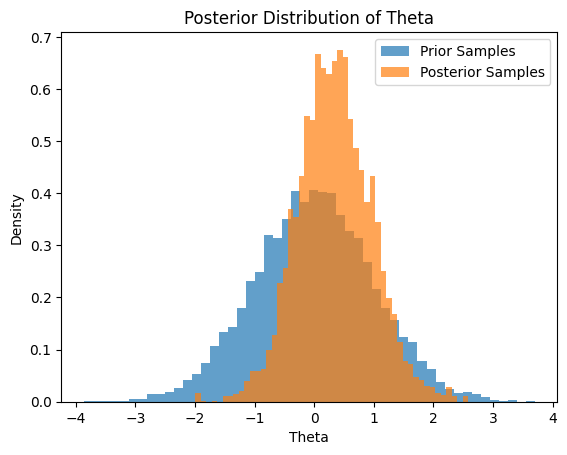

In [3]:
import torch
import torch.distributions as dist

# Define the prior: Normal(mu, sigma)

def prior(theta, mu=0.0, sigma=1.0):
    return dist.Normal(mu, sigma).log_prob(theta)

# Define the likelihood: Bernoulli(f(theta)), where f(theta) = sigmoid(theta)
def likelihood(theta, y, f=None):
    if f is None:
        f_theta = torch.sigmoid(theta)  # f(theta) = logistic function
    else:
        f_theta = f(theta)
    return y * torch.log(f_theta) + (1 - y) * torch.log(1 - f_theta)

# Define the target posterior (up to proportionality)
def log_posterior(theta, y, mu=0.0, sigma=1.0):
    return likelihood(theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(y, num_samples=10000, burn_in=1000, mu=0.0, sigma=1.0, proposal_std=1.0):
    samples = []
    theta = torch.tensor(0.0)  # Initial value of theta
    current_log_posterior = log_posterior(theta, y, mu, sigma)

    for i in range(num_samples + burn_in):
        # Propose a new theta' using a symmetric proposal distribution
        proposal = torch.normal(theta, proposal_std)  # Gaussian proposal q(theta'|theta)

        # Compute log-posterior for the proposal
        proposed_log_posterior = log_posterior(proposal, y, mu, sigma)

        # Compute the acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.item())

    return torch.tensor(samples)

# Example usage
# Observations (y): binary data from a Bernoulli distribution
y = torch.tensor([1, 0, 1, 1, 0, 1, 0, 1], dtype=torch.float32)

# Run Metropolis-Hastings
samples = metropolis_hastings(y, num_samples=5000, burn_in=1000, mu=0.0, sigma=1.0, proposal_std=0.5)

mean, std = samples.mean(), samples.std()

print(f"prior mean: 0, prior std: 1")
print(f"Posterior mean: {mean:.2f}, Posterior std: {std:.2f}")

# Analyze and visualize results
import matplotlib.pyplot as plt
# plot prior samples
plt.hist(dist.Normal(0, 1).sample((10000,)).numpy(), bins=50, density=True, alpha=0.7, label='Prior Samples')

# Plot the posterior samples
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.7, label='Posterior Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()


## metropolis multivariate

/tmp/ipykernel_44160/3264965549.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(samples)


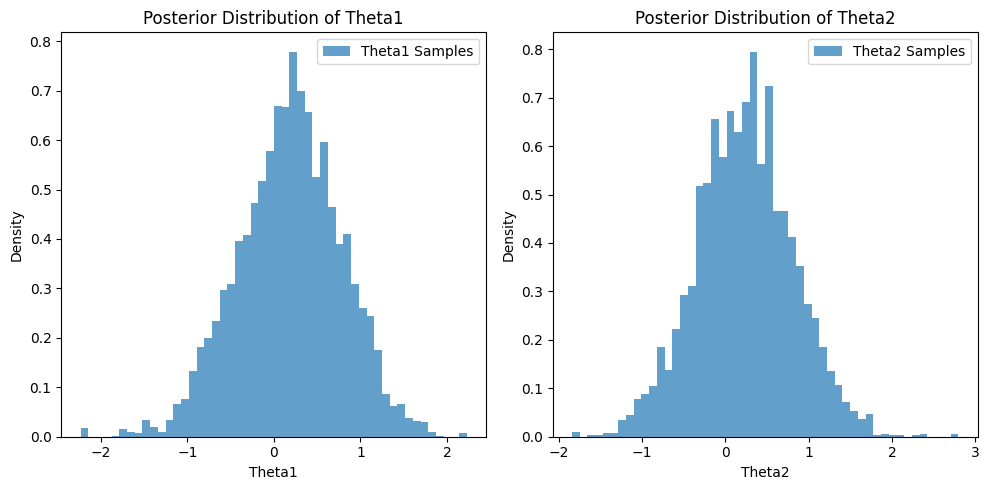

In [4]:
import torch
import torch.distributions as dist

# Define the multivariate Gaussian prior: N(mu, Sigma)
def prior(theta, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    mu: Tensor of shape (2,) representing [mu1, mu2].
    sigma: Tensor of shape (2, 2), covariance matrix.
    """
    mvn = dist.MultivariateNormal(mu, sigma)
    return mvn.log_prob(theta)

# Define the likelihood: Bernoulli(f(theta)), where f(theta) = sigmoid(w^T theta)
def likelihood(theta, y):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    y: Tensor of observed binary outcomes (0 or 1).
    """
    # Use a linear predictor f(theta) = sigmoid(w^T theta), for example w = [1, 1]
    w = torch.tensor([1.0, 1.0])
    f_theta = torch.sigmoid(torch.dot(w, theta))
    return y * torch.log(f_theta) + (1 - y) * torch.log(1 - f_theta)

# Define the posterior (up to proportionality)
def log_posterior(theta, y, mu, sigma):
    """
    theta: Tensor of shape (2,) representing [theta1, theta2].
    """
    return likelihood(theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(y, num_samples=10000, burn_in=1000, mu=None, sigma=None, proposal_std=0.5):
    """
    y: Observed binary outcomes (0 or 1).
    num_samples: Number of samples to draw from posterior.
    burn_in: Number of initial samples to discard.
    mu: Tensor of shape (2,) representing the prior mean vector.
    sigma: Tensor of shape (2, 2), the prior covariance matrix.
    proposal_std: Standard deviation for the proposal distribution.
    """
    if mu is None:
        mu = torch.tensor([0.0, 0.0])
    if sigma is None:
        sigma = torch.eye(2)  # Identity covariance matrix by default

    samples = []
    theta = torch.zeros(2)  # Initial value for [theta1, theta2]
    current_log_posterior = log_posterior(theta, y, mu, sigma)

    # Define proposal distribution
    proposal_cov = torch.eye(2) * proposal_std**2

    for i in range(num_samples + burn_in):
        # Propose new theta' using a multivariate normal proposal
        proposal = dist.MultivariateNormal(theta, proposal_cov).sample()

        # Compute the log-posterior for the proposal
        proposed_log_posterior = log_posterior(proposal, y, mu, sigma)

        # Compute acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.numpy())

    return torch.tensor(samples)

# Example usage
# Observations (y): binary data from a Bernoulli distribution
y = torch.tensor([1, 0, 1, 1, 0, 1, 0, 1], dtype=torch.float32)

# Define prior parameters
mu = torch.tensor([0.0, 0.0])  # Mean of the prior
sigma = torch.tensor([[1.0, 0.5], [0.5, 1.0]])  # Covariance matrix of the prior

# Run Metropolis-Hastings
samples = metropolis_hastings(y, num_samples=5000, burn_in=1000, mu=mu, sigma=sigma, proposal_std=0.5)

# Analyze and visualize results
import matplotlib.pyplot as plt

# Extract theta1 and theta2 samples
theta1_samples = samples[:, 0].numpy()
theta2_samples = samples[:, 1].numpy()

# Plot the posterior samples
plt.figure(figsize=(10, 5))

# Theta1 histogram
plt.subplot(1, 2, 1)
plt.hist(theta1_samples, bins=50, density=True, alpha=0.7, label='Theta1 Samples')
plt.title("Posterior Distribution of Theta1")
plt.xlabel("Theta1")
plt.ylabel("Density")
plt.legend()

# Theta2 histogram
plt.subplot(1, 2, 2)
plt.hist(theta2_samples, bins=50, density=True, alpha=0.7, label='Theta2 Samples')
plt.title("Posterior Distribution of Theta2")
plt.xlabel("Theta2")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


# variational inference

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
            
            # Predicted y
            y_pred = X @ theta #function of  X=(x,y) and theta sampled from variational distribution q_lambda
            
            # Log likelihood
            log_likelihood = likelihood(y, y_pred, noise_std) # function of y, y_pred and noise_std as observation model of the pomdp
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist

# Synthetic data for Bayesian linear regression
torch.manual_seed(42)
X = torch.randn(100, 2)  # 100 samples, 2 features
true_theta = torch.tensor([2.0, -1.0])
y = X @ true_theta + 0.1 * torch.randn(100)
print(X.shape, true_theta.shape, y.shape)

# Initialize variational distribution
variational_dist = VariationalDistribution(dim=2)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=100, num_samples=100, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")


torch.Size([100, 2]) torch.Size([2]) torch.Size([100])
Epoch 100, ELBO: -112.0604
Variational Mean: [ 2.0206351 -0.9992352]
Variational Log Std: [-1.8429017 -1.9003012]


In [78]:
from torch.distributions import Normal

mu = torch.tensor([0.0, 5.0])
sigma = torch.tensor([1.0, 0.5])
mvn = Normal(mu, sigma)
mvn.sample()

tensor([1.7266, 5.5423])

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
            
            # Predicted y
            y_pred = X @ theta #function of  X=(x,y) and theta sampled from variational distribution q_lambda
            
            # Log likelihood
            log_likelihood = likelihood(y, y_pred, noise_std) # function of y, y_pred and noise_std as observation model of the pomdp
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist

# Synthetic data for Bayesian linear regression with 4 parameters
torch.manual_seed(42)
X = torch.randn(100, 4)  # 100 samples, 4 features
true_theta = torch.tensor([2.0, -1.0, 0.5, -0.7])
y = X @ true_theta + 0.1 * torch.randn(100)
print(X.shape, true_theta.shape, y.shape)

# Initialize variational distribution for 4 parameters
variational_dist = VariationalDistribution(dim=4)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=100, num_samples=100, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")


torch.Size([100, 4]) torch.Size([4]) torch.Size([100])
Epoch 100, ELBO: -470.8313
Variational Mean: [ 2.0126462  -0.9947886   0.49327692 -0.6927638 ]
Variational Log Std: [-1.7756165 -1.8554561 -1.9046326 -1.8659397]


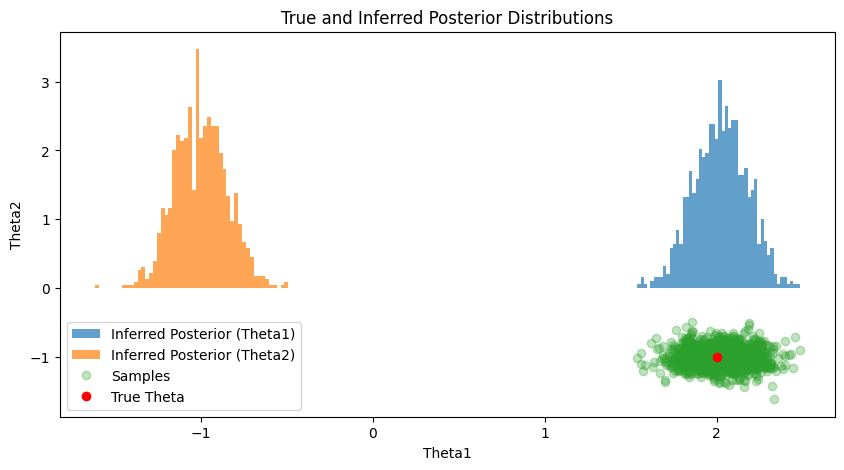

In [6]:
# Plot the true and inferred posterior distributions by sampling
import matplotlib.pyplot as plt

# True posterior
true_posterior = Normal(true_theta, torch.tensor([0.1, 0.1]))

# Inferred posterior
num_samples = 1000
samples = trained_dist.sample(num_samples).detach().numpy()

# Plot the true and inferred posterior distributions
plt.figure(figsize=(10, 5))
plt.hist(samples[:, 0], bins=50, density=True, alpha=0.7, label='Inferred Posterior (Theta1)')
plt.hist(samples[:, 1], bins=50, density=True, alpha=0.7, label='Inferred Posterior (Theta2)')
plt.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.3, label='Samples')
plt.plot(true_theta[0], true_theta[1], 'ro', label='True Theta')
plt.xlabel("Theta1")
plt.ylabel("Theta2")
plt.title("True and Inferred Posterior Distributions")
plt.legend()
plt.show()


In [68]:
from torch.distributions import MultivariateNormal
mu = torch.tensor([0.0, 0.0])
sigma = torch.tensor([[1.0, 0.], [0., 1.0]])
MultivariateNormal(mu, sigma).log_prob(torch.tensor([0.0, 0.0])).sum()

tensor(-1.8379)

# VI class 2 estimatir

In [27]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim import Adam
import numpy as np

class VariationalBayesianInference:
    def __init__(self, f, input_dim, latent_dim=1, hidden_dim=32):
        """
        Initialize the variational Bayesian inference model.
        
        Args:
            f: callable, the known function linking X and y through theta
            input_dim: int, dimension of input X
            latent_dim: int, dimension of latent parameter theta
            hidden_dim: int, dimension of hidden layers in the neural network
        """
        self.f = f
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Variational parameters (mean and log variance of q(theta))
        self.q_mu = nn.Parameter(torch.randn(latent_dim))
        self.q_logvar = nn.Parameter(torch.zeros(latent_dim))
        
        # Prior parameters (assumed to be standard normal)
        # self.prior = dist.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
        # prior_mu = torch.tensor([torch.mean(torch.tensor(pomdp_env.stretch_range)),
        #             torch.mean(torch.tensor(pomdp_env.shear_range)),
        #             torch.mean(torch.tensor(pomdp_env.shear_range)),
        #             torch.mean(torch.tensor(pomdp_env.stretch_range))])
        # prior_sigma = torch.tensor([1,1,1,1])
        prior_mu = torch.zeros(latent_dim)
        prior_sigma = torch.ones(latent_dim)
        self.prior = dist.Normal(prior_mu, prior_sigma)

        
    def sample_latent(self, n_samples=1):
        """Sample from the variational distribution q(theta)"""
        eps = torch.randn(n_samples, self.latent_dim)
        std = torch.exp(0.5 * self.q_logvar)
        return self.q_mu + eps * std
    
    def elbo(self, X, y, n_samples=10):
        """
        Compute the evidence lower bound (ELBO)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
            n_samples: int, number of Monte Carlo samples
        """
        batch_size = X.shape[0]
        
        # Sample from variational distribution
        theta_samples = self.sample_latent(n_samples)  # (n_samples, latent_dim)
        
        # Compute log likelihood for each sample
        log_likelihood = torch.zeros(n_samples, batch_size)
        for i in range(n_samples):
            theta = theta_samples[i]
            # y_pred = self.f(X, theta.repeat(batch_size, 1))
            y_pred = X @ theta
            # Assuming Bernoulli observation model
            log_likelihood[i] = dist.Normal(y_pred,0.1).log_prob(y)
        
        # Average over samples
        expected_log_likelihood = torch.mean(log_likelihood, dim=0).sum()

        # if expected_log_likelihood == dist.Bernoulli(self.f(X,theta_samples)).log_prob(y).sum():
        #     print('ok should substitute the for loop with the above line')
        
        # Compute KL divergence
        q_dist = dist.Normal(self.q_mu, torch.exp(0.5 * self.q_logvar))
        kl_div = dist.kl_divergence(q_dist, self.prior).sum()
        
        return expected_log_likelihood - kl_div
    
    def fit(self, X, y, n_epochs=100, batch_size=64, lr=0.1):
        """
        Fit the model using variational inference
        
        Args:
            X: torch.Tensor, input data
            y: torch.Tensor, observations
            n_epochs: int, number of training epochs
            batch_size: int, batch size for stochastic optimization
            lr: float, learning rate
        """
        optimizer = Adam([self.q_mu, self.q_logvar], lr=lr)
        
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_epochs):
            epoch_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                loss = -self.elbo(batch_X, batch_y, 300)  # Negative because we minimize
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    
    def get_posterior_params(self):
        """Return the learned posterior parameters"""
        return {
            'mean': self.q_mu.detach(),
            'std': torch.exp(0.5 * self.q_logvar).detach()
        }

In [34]:
# Synthetic data for Bayesian linear regression with 4 parameters
torch.manual_seed(42)
X = torch.randn(100, 4)  # 100 samples, 4 features
true_theta = torch.tensor([2.0, -1.0, 0.5, -0.7])
y = X @ true_theta + 0.1 * torch.randn(100)

# Initialize variational distribution for 4 parameters
model = VariationalBayesianInference(None, input_dim=2, latent_dim=4)
model.fit(X, y)

# Output trained variational parameters
posterior = model.get_posterior_params()
print("Estimated theta (mean):", posterior['mean'])
print("Posterior standard deviation:", posterior['std'])

print("True theta:", true_theta)

Epoch 10/100, Loss: 3339.8273
Epoch 20/100, Loss: 1095.9770
Epoch 30/100, Loss: 451.8245
Epoch 40/100, Loss: 327.1066
Epoch 50/100, Loss: 224.4476
Epoch 60/100, Loss: 177.9649
Epoch 70/100, Loss: 147.2128
Epoch 80/100, Loss: 108.5931
Epoch 90/100, Loss: 87.2211
Epoch 100/100, Loss: 74.0786
Estimated theta (mean): tensor([ 1.9926, -1.0085,  0.4906, -0.7088])
Posterior standard deviation: tensor([0.1043, 0.1076, 0.1091, 0.1081])
True theta: tensor([ 2.0000, -1.0000,  0.5000, -0.7000])


In [36]:
X.shape, true_theta.shape

(torch.Size([100, 4]), torch.Size([4]))

In [2]:
import torch
a = torch.tensor([[1,2,3,4],[1,2,3,5]])
b = torch.tensor([1,1,1,1])
print(a.shape, b.shape)
print(a@b)

torch.Size([2, 4]) torch.Size([4])
tensor([10, 11])


# Laplace

In [26]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim import Adam, LBFGS
import numpy as np
from scipy.stats import norm

class LaplaceApproximation:
    
    def __init__(self, f, input_dim, param_dim=1):
        """
        Initialize the Laplace Approximation model.
        
        Args:
            f: callable, the known function linking X and y through theta
            input_dim: int, dimension of input X
            param_dim: int, dimension of parameter theta
        """
        self.f = f
        self.input_dim = input_dim
        self.param_dim = param_dim
        
        # Initialize MAP estimate
        self.theta_map = nn.Parameter(torch.zeros(param_dim))
        
        # Storage for the computed Hessian at MAP
        self.hessian = None
        self.posterior_cov = None
        
    def neg_log_posterior(self, X, y):
        """
        Compute negative log posterior (up to a constant)
        
        Args:
            X: torch.Tensor, input data (batch_size, input_dim)
            y: torch.Tensor, observations (batch_size,)
        """
        # Compute likelihood (assuming Bernoulli for binary classification)
        y_pred = self.f(X, self.theta_map)# .squeeze()  expand(X.shape[0], -1)
        log_likelihood = dist.Bernoulli(y_pred).log_prob(y).sum()
        
        # Add prior (assuming standard normal prior)
        log_prior = dist.Normal(0, 1).log_prob(self.theta_map).sum()
        
        return -(log_likelihood + log_prior)
    
    def compute_hessian(self, X, y):
        """
        Compute the Hessian of the negative log posterior at the MAP estimate
        """
        # Compute gradient of loss with respect to theta
        loss = self.neg_log_posterior(X, y)
        grad = torch.autograd.grad(loss, self.theta_map, create_graph=True)[0]
        
        # Compute Hessian
        hessian = torch.zeros(self.param_dim, self.param_dim)
        for i in range(self.param_dim):
            grad_i = grad[i]
            hess_row = torch.autograd.grad(grad_i, self.theta_map, retain_graph=True)[0]
            hessian[i] = hess_row
            
        return hessian
    
    def fit(self, X, y, n_iterations=1000, lr=0.1, method='adam'):
        """
        Find MAP estimate and compute Hessian for Laplace approximation
        
        Args:
            X: torch.Tensor, input data
            y: torch.Tensor, observations
            n_iterations: int, number of optimization iterations
            lr: float, learning rate (for Adam)
            method: str, optimization method ('adam' or 'lbfgs')
        """
        if method == 'adam':
            optimizer = Adam([self.theta_map], lr=lr)
            
            for i in range(n_iterations):
                optimizer.zero_grad()
                loss = self.neg_log_posterior(X, y)
                loss.backward()
                optimizer.step()
                
                if (i + 1) % 100 == 0:
                    print(f"Iteration {i+1}/{n_iterations}, Loss: {loss.item():.4f}")
                    print(f"MAP estimate: {self.theta_map.detach().numpy()}")
        
        elif method == 'lbfgs':
            optimizer = LBFGS([self.theta_map], lr=lr)
            
            def closure():
                optimizer.zero_grad()
                loss = self.neg_log_posterior(X, y)
                loss.backward()
                return loss
            
            for i in range(n_iterations):
                optimizer.step(closure)
                
                if (i + 1) % 100 == 0:
                    loss = self.neg_log_posterior(X, y)
                    print(f"Iteration {i+1}/{n_iterations}, Loss: {loss.item():.4f}")
                    print(f"MAP estimate: {self.theta_map.detach().numpy()}")
        
        # Compute Hessian at MAP estimate
        self.hessian = self.compute_hessian(X, y)
        
        # Compute posterior covariance (inverse of Hessian)
        self.posterior_cov = torch.inverse(self.hessian)
        
    def sample_posterior(self, n_samples=1000):
        """
        Draw samples from the Laplace approximation to the posterior
        """
        if self.posterior_cov is None:
            raise ValueError("Must call fit() before sampling")
        
        # Create multivariate normal distribution
        mvn = dist.MultivariateNormal(self.theta_map, self.posterior_cov)
        
        # Draw samples
        return mvn.sample((n_samples,))
    
    def get_posterior_params(self):
        """Return the parameters of the Gaussian approximation"""
        if self.posterior_cov is None:
            raise ValueError("Must call fit() before getting parameters")
            
        return {
            'mean': self.theta_map.detach(),
            'covariance': self.posterior_cov.detach(),
            'std': torch.sqrt(torch.diag(self.posterior_cov)).detach()
        }
    
    def predict(self, X_new, n_samples=1000):
        """
        Make predictions at new points using the approximate posterior
        
        Args:
            X_new: torch.Tensor, new input points
            n_samples: int, number of posterior samples to use
        """
        theta_samples = self.sample_posterior(n_samples)
        
        # Compute predictions for each sample
        predictions = []
        for theta in theta_samples:
            y_pred = self.f(X_new, theta)# .squeeze() # .expand(X_new.shape[0], -1)
            predictions.append(y_pred)
            
        # Stack predictions
        predictions = torch.stack(predictions)
        
        # Compute mean and standard deviation
        pred_mean = torch.mean(predictions, dim=0)
        pred_std = torch.std(predictions, dim=0)
        
        return pred_mean, pred_std
    
    def get_credible_interval(self, alpha=0.05):
        """
        Compute credible intervals for each parameter
        
        Args:
            alpha: float, significance level (e.g., 0.05 for 95% CI)
        """
        if self.posterior_cov is None:
            raise ValueError("Must call fit() before computing intervals")
            
        mean = self.theta_map
        std = torch.sqrt(torch.diag(self.posterior_cov))
        
        z_score = norm.ppf(1 - alpha/2)
        lower = mean - z_score * std
        upper = mean + z_score * std
        
        return lower.detach(), upper.detach()

True parameters: [0.2, -0.2]
Fitting Laplace Approximation...
Iteration 100/100, Loss: 6920.8848
MAP estimate: [ 0.22614916 -0.25805092]


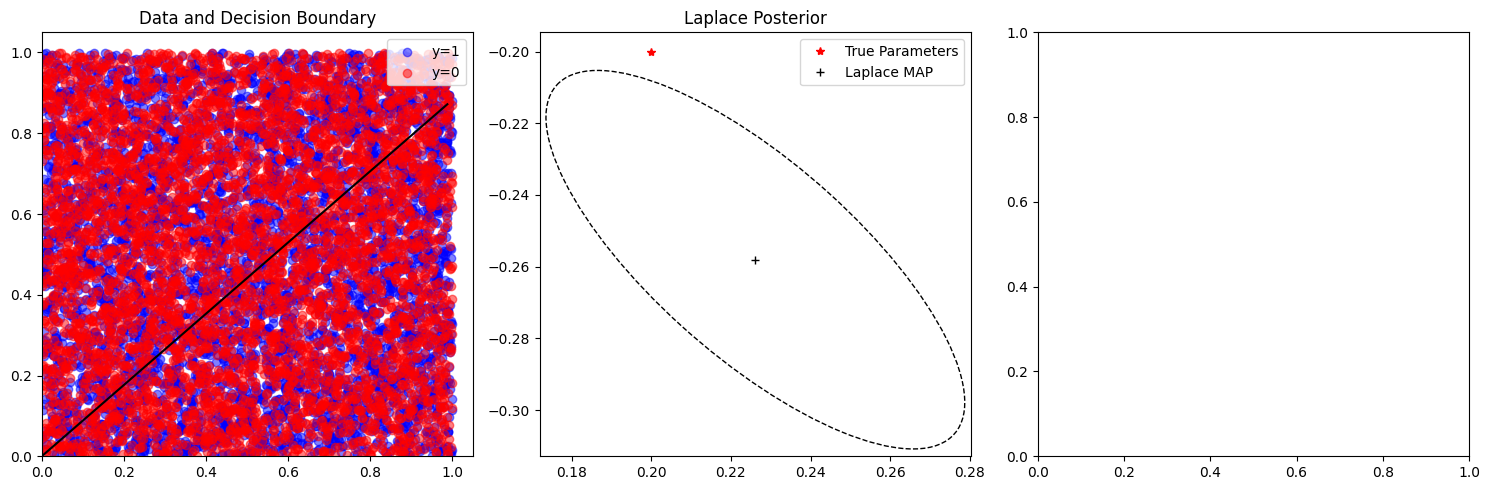


True parameters: [0.2, -0.2]

Laplace Approximation results:
MAP estimate: [ 0.22614916 -0.25805092]
Posterior std: [0.0525885  0.05279891]


In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import seaborn as sns

# First, import our previous implementations
# Assuming they're saved in files called laplace_approximation.py and beta_variational.py

def generate_synthetic_data(n_samples=100, true_params=[0.2, -0.2], noise=0.1):
    """
    Generate synthetic binary classification data
    """
    # Generate random input features
    X = torch.rand(n_samples, 2)  # 2D input features
    
    # True function (logistic regression)
    def true_function(X, params):
        return torch.sigmoid(X @ torch.tensor(params))
    
    # Generate noisy observations
    probs = true_function(X, true_params)
    # y = torch.bernoulli(probs)
    y = torch.distributions.Bernoulli(probs).sample()
    
    return X, y, true_params

def forward_model(X, theta):
    """
    Forward model for both inference methods
    """
    return torch.sigmoid(X @ theta)

def main():
    # Set random seed for reproducibility
    # torch.manual_seed(4242)
    # np.random.seed(422345)
    
    # Generate synthetic dataset
    n_samples = 10000
    X, y, true_params = generate_synthetic_data(n_samples)
    print("True parameters:", true_params)
    
    # Initialize both models
    laplace_model = LaplaceApproximation(f=forward_model, input_dim=2, param_dim=2)
    
    # Fit Laplace Approximation
    print("Fitting Laplace Approximation...")
    laplace_model.fit(X, y, n_iterations=100, method='lbfgs', lr=0.1)
    laplace_params = laplace_model.get_posterior_params()
    laplace_samples = laplace_model.sample_posterior(n_samples=1000)
        
    # Plotting results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Data and decision boundary
    plt.subplot(131)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label='y=1', alpha=0.5)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label='y=0', alpha=0.5)
    
    # Create grid for decision boundary
    xx, yy = np.mgrid[0:1:.01, 0:1:.01]
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    
    # Plot Laplace decision boundary
    with torch.no_grad():
        pred_mean, pred_std = laplace_model.predict(grid)
    plt.contour(xx, yy, pred_mean.numpy().reshape(xx.shape), levels=[0.5], colors='k')
    
    plt.title('Data and Decision Boundary')
    plt.legend()
    
    # Plot 2: Laplace posterior samples
    plt.subplot(132)
    # sns.kdeplot(data=laplace_samples.numpy(), x=0, y=1)
    plt.plot(true_params[0], true_params[1], 'r*', label='True Parameters')
    plt.plot(laplace_params['mean'][0], laplace_params['mean'][1], 'k+', 
             label='Laplace MAP')
    
    # Plot error ellipse
    from matplotlib.patches import Ellipse
    eigenvals, eigenvecs = np.linalg.eigh(laplace_params['covariance'].numpy())
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    ellip = Ellipse(xy=laplace_params['mean'].numpy(),
                    width=2*np.sqrt(eigenvals[0]), height=2*np.sqrt(eigenvals[1]),
                    angle=angle, fill=False, color='k', linestyle='--')
    plt.gca().add_patch(ellip)
    plt.title('Laplace Posterior')
    plt.legend()
    
    # Plot 3: Parameter convergence
    plt.subplot(133)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nTrue parameters:", true_params)
    print("\nLaplace Approximation results:")
    print("MAP estimate:", laplace_params['mean'].numpy())
    print("Posterior std:", laplace_params['std'].numpy())
    
if __name__ == "__main__":
    main()

/tmp/ipykernel_49179/4021240243.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_49179/4021240243.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).to(device)


Epoch 0, Loss: 71.1526
Epoch 10, Loss: 65.6371
Epoch 20, Loss: 65.0506
Epoch 30, Loss: 65.0307
Epoch 40, Loss: 64.9333
Epoch 50, Loss: 64.9228
Epoch 60, Loss: 64.9247
Epoch 70, Loss: 64.9221
Epoch 80, Loss: 64.9204
Epoch 90, Loss: 64.9199

Results:
True parameters: [ 0.7 -0.5]
MAP estimate: [ 0.5922143  -0.41874748]
Relative Error: tensor(0.1569)
Posterior standard deviations: [0.22578013 0.21235816]

Predictions for test points:
Point 1: 0.542 (0.393, 0.682)
Point 2: 0.500 (0.500, 0.500)
Point 3: 0.458 (0.318, 0.607)


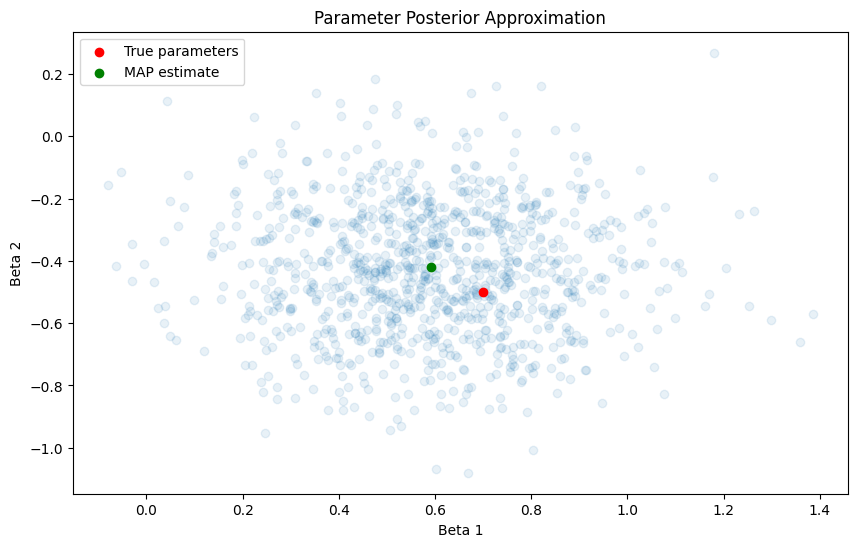

/tmp/ipykernel_49179/4021240243.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).to(device)
/tmp/ipykernel_49179/4021240243.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).to(device)


Epoch 0, Loss: 694.9852
Epoch 10, Loss: 635.6669
Epoch 20, Loss: 633.6577
Epoch 30, Loss: 632.5583
Epoch 40, Loss: 631.2756
Epoch 50, Loss: 631.3872
Epoch 60, Loss: 631.3113
Epoch 70, Loss: 631.2457
Epoch 80, Loss: 631.2383
Epoch 90, Loss: 631.2397

Results:
True parameters: [ 0.7 -0.5]
MAP estimate: [ 0.6638428  -0.47576553]
Relative Error: tensor(0.0506)
Posterior standard deviations: [0.07297483 0.07034466]

Predictions for test points:
Point 1: 0.547 (0.505, 0.589)
Point 2: 0.500 (0.500, 0.500)
Point 3: 0.453 (0.411, 0.495)


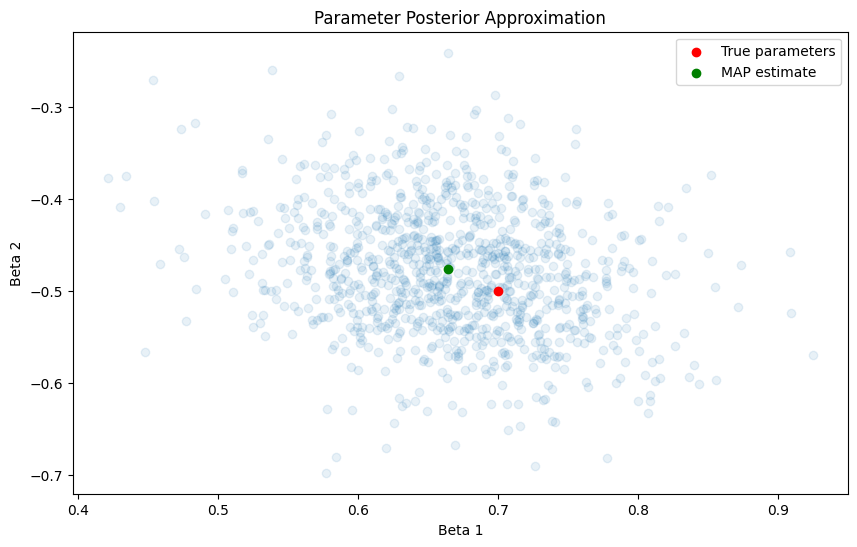

Epoch 0, Loss: 6933.3110
Epoch 10, Loss: 6298.0278
Epoch 20, Loss: 6267.3120
Epoch 30, Loss: 6257.0981
Epoch 40, Loss: 6244.6733
Epoch 50, Loss: 6245.8647
Epoch 60, Loss: 6245.1865
Epoch 70, Loss: 6244.5049
Epoch 80, Loss: 6244.4028
Epoch 90, Loss: 6244.4097

Results:
True parameters: [ 0.7 -0.5]
MAP estimate: [ 0.65256345 -0.49886864]
Relative Error: tensor(0.0552)
Posterior standard deviations: [0.02319803 0.02260942]

Predictions for test points:
Point 1: 0.538 (0.523, 0.554)
Point 2: 0.500 (0.500, 0.500)
Point 3: 0.462 (0.446, 0.477)


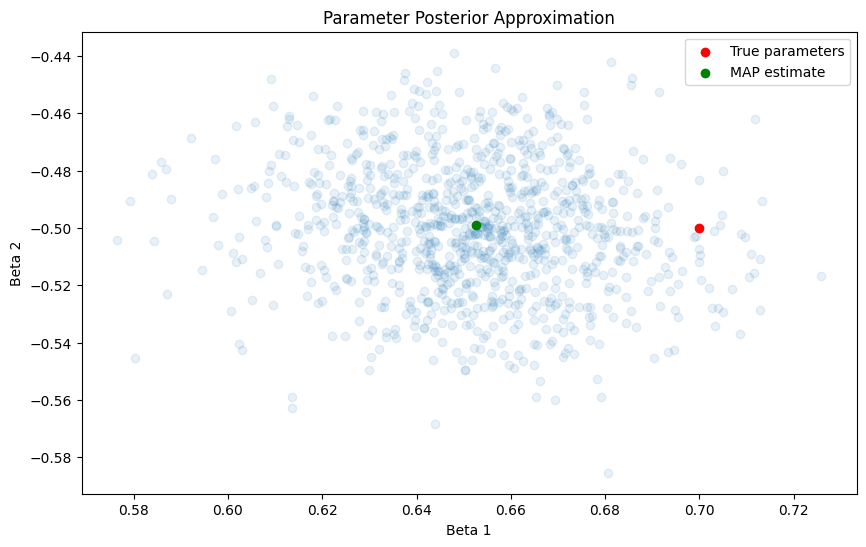

Epoch 0, Loss: 69316.5781
Epoch 10, Loss: 62640.8125
Epoch 20, Loss: 62475.8945
Epoch 30, Loss: 62267.4219
Epoch 40, Loss: 62174.4805
Epoch 50, Loss: 62190.9961
Epoch 60, Loss: 62174.8750
Epoch 70, Loss: 62169.7734
Epoch 80, Loss: 62170.0391
Epoch 90, Loss: 62169.8516

Results:
True parameters: [ 0.7 -0.5]
MAP estimate: [ 0.68615085 -0.4974048 ]
Relative Error: tensor(0.0164)
Posterior standard deviations: [0.00749502 0.00719535]

Predictions for test points:
Point 1: 0.547 (0.542, 0.552)
Point 2: 0.500 (0.500, 0.500)
Point 3: 0.453 (0.448, 0.458)


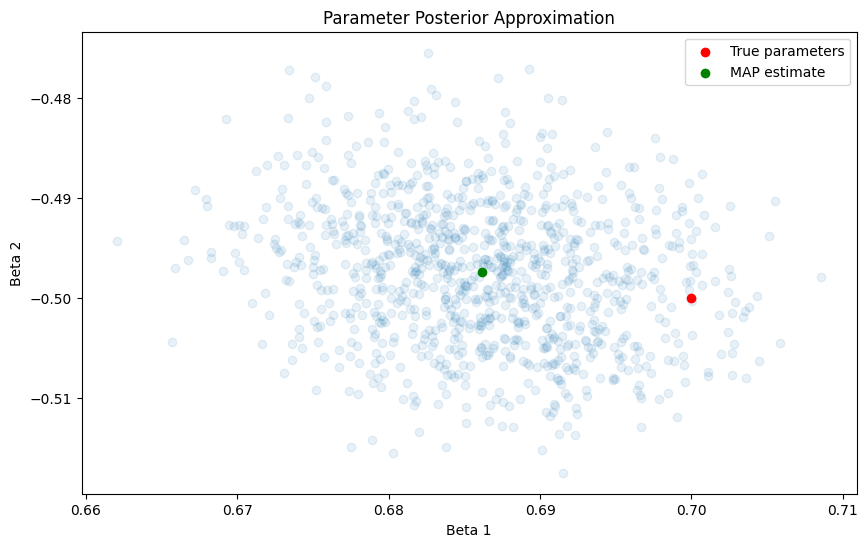

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

class BernoulliModel(nn.Module):
    def __init__(self, n_features):
        """
        Initialize the Bernoulli model
        
        Parameters:
        n_features (int): Number of input features
        """
        super().__init__()
        self.beta = nn.Parameter(torch.zeros(n_features))
    
    def forward(self, X):
        """
        Compute the Bernoulli distribution
        """
        linear_pred = X @ self.beta
        probs = torch.sigmoid(linear_pred)
        return dist.Bernoulli(probs=probs)

class LaplaceApproximation:
    def __init__(self, X, y, device='cpu'):
        """
        Initialize the Laplace Approximation for Bayesian Logistic Regression
        
        Parameters:
        X (array-like): Feature matrix
        y (array-like): Binary target variable (0 or 1)
        device (str): 'cpu' or 'cuda'
        """
        self.device = device
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.n_features = X.shape[1]
        
        # Initialize model
        self.model = BernoulliModel(self.n_features).to(device)
        
    def negative_log_posterior(self):
        """
        Compute the negative log posterior (up to a constant)
        """
        # Prior (standard normal)
        prior = dist.Normal(0, 1)
        log_prior = prior.log_prob(self.model.beta).sum()
        
        # Likelihood (Bernoulli)
        bernoulli_dist = self.model(self.X)
        log_likelihood = bernoulli_dist.log_prob(self.y).sum()
        
        return -(log_prior + log_likelihood)
    
    def fit(self, n_epochs=1000, lr=0.1):
        """
        Perform Laplace approximation
        
        Parameters:
        n_epochs (int): Number of optimization iterations
        lr (float): Learning rate for optimization
        """
        # Find MAP estimate using Adam optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            loss = self.negative_log_posterior()
            loss.backward()
            optimizer.step()
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
        # Store MAP estimate
        self.beta_map = self.model.beta.detach().clone()
        
        # Compute Hessian at MAP using autograd
        hessian = torch.zeros((self.n_features, self.n_features)).to(self.device)
        
        for i in range(self.n_features):
            self.model.zero_grad()
            loss = self.negative_log_posterior()
            grad = torch.autograd.grad(loss, self.model.beta, create_graph=True)[0]
            
            for j in range(self.n_features):
                hessian[i,j] = torch.autograd.grad(grad[j], self.model.beta, retain_graph=True)[0][i]
        
        # Posterior covariance is inverse of Hessian
        self.posterior_cov = torch.inverse(hessian).cpu().numpy()
        self.beta_map = self.beta_map.cpu().numpy()
    
    def predict_proba(self, X_new, n_samples=1000):
        """
        Predict probabilities and generate samples for new data points
        
        Parameters:
        X_new (array-like): New feature matrix
        n_samples (int): Number of samples to draw from approximate posterior
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        
        # Draw samples from approximate posterior
        beta_samples = torch.tensor(
            np.random.multivariate_normal(self.beta_map, self.posterior_cov, n_samples),
            dtype=torch.float32
        )
        
        # Compute probabilities and draw samples for each beta
        all_probs = []
        all_samples = []
        
        for beta in beta_samples:
            linear_pred = X_new @ beta
            probs = torch.sigmoid(linear_pred)
            bernoulli_dist = dist.Bernoulli(probs=probs)
            
            all_probs.append(probs.numpy())
            all_samples.append(bernoulli_dist.sample().numpy())
        
        # Calculate statistics
        probs = np.array(all_probs)
        samples = np.array(all_samples)
        
        mean_probs = np.mean(probs, axis=0)
        lower = np.percentile(probs, 2.5, axis=0)
        upper = np.percentile(probs, 97.5, axis=0)
        
        return mean_probs, lower, upper, samples

# Test the implementation
if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(np.random.randint(31985))
    np.random.seed(np.random.randint(31985))
    
    # Generate synthetic data
    for n_samples in [100, 1000, 10000,100000]:
        n_features = 2
        
        # True parameters
        true_beta = torch.tensor([.7, -0.5])
        
        # Generate features
        X = torch.randn(n_samples, n_features)
        
        # Generate responses using Bernoulli distribution
        linear_pred = X @ true_beta
        probs = torch.sigmoid(linear_pred)
        bernoulli_dist = dist.Bernoulli(probs=probs)
        y = bernoulli_dist.sample()
        
        # Fit model
        model = LaplaceApproximation(X, y)
        model.fit(n_epochs=100)
        
        # Print results
        print("\nResults:")
        print("True parameters:", true_beta.numpy())
        print("MAP estimate:", model.beta_map)
        print("Relative Error:", torch.norm(torch.tensor(model.beta_map) - true_beta) / torch.norm(true_beta))
        print("Posterior standard deviations:", np.sqrt(np.diag(model.posterior_cov)))

        
        # Make predictions
        X_test = np.array([[1.0, 1.0], [0.0, 0.0], [-1.0, -1.0]])
        mean_probs, lower, upper, samples = model.predict_proba(X_test)
        
        print("\nPredictions for test points:")
        for i, (mean, l, u) in enumerate(zip(mean_probs, lower, upper)):
            print(f"Point {i+1}: {mean:.3f} ({l:.3f}, {u:.3f})")
        
        # Plot parameter posterior approximation
        plt.figure(figsize=(10, 6))
        samples = np.random.multivariate_normal(model.beta_map, model.posterior_cov, 1000)
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
        plt.scatter(true_beta[0].item(), true_beta[1].item(), color='red', label='True parameters')
        plt.scatter(model.beta_map[0], model.beta_map[1], color='green', label='MAP estimate')
        plt.xlabel('Beta 1')
        plt.ylabel('Beta 2')
        plt.legend()
        plt.title('Parameter Posterior Approximation')
        plt.show()

# Particle Filter

In [2]:
import torch
import torch.distributions as dist
import numpy as np

class BayesianParticleFilter:
    def __init__(self, n_particles=1000):
        """
        Initialize the particle filter for Bayesian linear regression.
        
        Args:
            n_particles (int): Number of particles to use for approximating the posterior
        """
        self.n_particles = n_particles
        self.particles = None
        self.weights = None
        
    def initialize_particles(self, prior_mean=0.0, prior_std=1.0):
        """
        Initialize particles from the prior distribution.
        
        Args:
            prior_mean (float): Mean of the prior distribution
            prior_std (float): Standard deviation of the prior distribution
        """
        # Sample initial particles from prior (assumed Gaussian)
        self.particles = torch.normal(prior_mean, prior_std, size=(self.n_particles,))
        # Initialize uniform weights
        self.weights = torch.ones(self.n_particles) / self.n_particles
        
    def log_likelihood(self, X, y, theta, noise_std=0.1):
        """
        Compute the log likelihood log p(y|X,theta) assuming Gaussian noise.
        
        Args:
            X (torch.Tensor): Input features
            y (torch.Tensor): Target values
            theta (torch.Tensor): Parameter particles
            noise_std (float): Standard deviation of observation noise
        
        Returns:
            torch.Tensor: Log likelihood values for each particle
        """
        # Compute predicted values for each particle
        y_pred = X * theta.unsqueeze(1)  # Shape: (n_particles, n_samples)
        
        # Compute log likelihood using Gaussian noise model
        log_likelihood = -0.5 * ((y - y_pred) ** 2).sum(dim=1) / (noise_std ** 2)
        # Add normalization constant
        log_likelihood -= 0.5 * len(X) * np.log(2 * np.pi * noise_std ** 2)
        return log_likelihood
    
    def update(self, X, y, noise_std=0.1):
        """
        Update particle weights based on new observations.
        
        Args:
            X (torch.Tensor): Input features
            y (torch.Tensor): Target values
            noise_std (float): Standard deviation of observation noise
        """
        # Compute log likelihood for each particle
        log_likelihoods = self.log_likelihood(X, y, self.particles, noise_std)
        
        # Update log weights
        log_weights = torch.log(self.weights) + log_likelihoods
        
        # Subtract maximum for numerical stability before exp
        log_weights_normalized = log_weights - torch.max(log_weights)
        self.weights = torch.exp(log_weights_normalized)
        
        # Normalize weights
        self.weights /= self.weights.sum()
        
        # Compute effective sample size
        eff_sample_size = 1.0 / (self.weights ** 2).sum()
        
        # Resample if effective sample size is too low
        if eff_sample_size < self.n_particles / 2:
            self.resample()
    
    def resample(self):
        """
        Resample particles according to their weights using systematic resampling.
        """
        # Compute cumulative sum of weights
        cumsum = torch.cumsum(self.weights, dim=0)
        
        # Generate systematic resampling points
        u = torch.rand(1)
        positions = (u + torch.arange(self.n_particles)) / self.n_particles
        
        # Resample particles
        indices = torch.searchsorted(cumsum, positions)
        self.particles = self.particles[indices]
        
        # Reset weights to uniform
        self.weights = torch.ones(self.n_particles) / self.n_particles
    
    def estimate_posterior(self):
        """
        Compute posterior mean and variance from particles.
        
        Returns:
            tuple: (posterior_mean, posterior_variance)
        """
        posterior_mean = (self.particles * self.weights).sum()
        posterior_var = ((self.particles - posterior_mean)**2 * self.weights).sum()
        return posterior_mean.item(), posterior_var.item()

# Example usage
def generate_synthetic_data(theta_true=2.0, n_samples=100, noise_std=0.1):
    """Generate synthetic data for testing."""
    X = torch.linspace(-1, 1, n_samples)
    y = theta_true * X + torch.normal(0, noise_std, size=(n_samples,))
    return X, y

In [25]:
# Generate synthetic data
X, y = generate_synthetic_data(theta_true=2.0, n_samples=16, noise_std=0.1)

# Initialize and run particle filter
pf = BayesianParticleFilter(n_particles=100)
pf.initialize_particles(prior_mean=0.0, prior_std=1.0)
prior_weights,prior_particles = pf.weights.clone(), pf.particles.clone()
# Update with observations
pf.update(X, y, noise_std=0.1)
posterior_weights, posterior_particles = pf.weights.clone(), pf.particles.clone()

# Get posterior estimates
post_mean, post_var = pf.estimate_posterior()
print(f"Posterior mean: {post_mean:.3f}")
print(f"Posterior std: {np.sqrt(post_var):.3f}")

Posterior mean: 1.886
Posterior std: 0.000


In [4]:
prior_particles, posterior_particles

(tensor([ 1.4252, -0.8735,  0.8471,  0.6663,  1.4801,  0.0495, -1.5911,  1.4177,
          1.9511,  0.6785,  0.6569, -0.1521, -1.0963,  1.6439, -0.2246,  0.3385,
          0.4113,  0.5381, -0.2247,  0.2228, -1.5824,  1.2253,  0.2655, -0.3341,
         -1.0796,  0.4911, -0.0992,  1.2138, -1.5239,  0.6069, -0.4972,  1.2262,
          0.1061, -0.3335,  0.6440, -0.0897,  0.6866, -0.9095, -0.9294,  0.1608,
          0.0930,  0.2640, -0.8492,  0.2509,  0.7027, -0.5417, -1.2687,  0.1512,
          1.2642,  0.7193, -1.3947, -0.2559, -1.4949,  0.1175,  1.7389, -1.5920,
          0.5116,  1.7656,  0.5273,  1.9508, -2.0339, -0.7986,  0.5167,  2.5318,
          0.2828,  0.8720, -0.3020,  0.2222,  2.1543, -1.3755,  0.5282,  0.2099,
         -1.2570, -0.1363, -0.8850, -0.0561,  0.0261,  1.2086,  0.1249, -0.7138,
          0.2487,  0.3062, -0.8279, -0.7680,  0.6351,  0.3839,  1.2403, -1.1478,
          0.5716,  1.4788, -0.0848,  0.1227, -0.9201,  0.9470, -2.3718,  0.9148,
          1.3816, -0.7149, -

In [326]:
prior_weights, posterior_weights

(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0

In [26]:
import torch
import torch.distributions as dist
import numpy as np

class BayesianParticleFilter2D:
    def __init__(self, n_particles=1000, theta_dim=2):
        """
        Initialize the particle filter for Bayesian linear regression with 2D parameters.
        
        Args:
            n_particles (int): Number of particles to use for approximating the posterior.
            theta_dim (int): Dimensionality of the parameter vector (default is 2).
        """
        self.n_particles = n_particles
        self.theta_dim = theta_dim
        self.particles = None
        self.weights = None
        
    def initialize_particles(self, prior_mean=0.0, prior_std=1.0):
        """
        Initialize particles from the prior distribution.
        
        Args:
            prior_mean (float): Mean of the prior distribution.
            prior_std (float): Standard deviation of the prior distribution.
        """
        # Sample initial particles from a multivariate Gaussian prior
        self.particles = torch.normal(
            prior_mean, prior_std, size=(self.n_particles, self.theta_dim)
        )
        # Initialize uniform weights
        self.weights = torch.ones(self.n_particles) / self.n_particles
        
    def log_likelihood(self, X, y, theta, noise_std=0.1):
        """
        Compute the log likelihood log p(y|X,theta) assuming Gaussian noise.
        
        Args:
            X (torch.Tensor): Input features (n_samples, theta_dim).
            y (torch.Tensor): Target values (n_samples,).
            theta (torch.Tensor): Parameter particles (n_particles, theta_dim).
            noise_std (float): Standard deviation of observation noise.
        
        Returns:
            torch.Tensor: Log likelihood values for each particle.
        """
        # Compute predicted values for each particle
        # Shape of y_pred: (n_particles, n_samples)
        y_pred = torch.matmul(theta, X.T)
        
        # Compute log likelihood using Gaussian noise model
        residuals = y - y_pred  # Shape: (n_particles, n_samples)
        log_likelihood = -0.5 * (residuals ** 2).sum(dim=1) / (noise_std ** 2)
        # Add normalization constant
        log_likelihood -= 0.5 * X.size(0) * np.log(2 * np.pi * noise_std ** 2)
        return log_likelihood
    
    def update(self, X, y, noise_std=0.1):
        """
        Update particle weights based on new observations.
        
        Args:
            X (torch.Tensor): Input features (n_samples, theta_dim).
            y (torch.Tensor): Target values (n_samples,).
            noise_std (float): Standard deviation of observation noise.
        """
        # Compute log likelihood for each particle
        log_likelihoods = self.log_likelihood(X, y, self.particles, noise_std)

        # Update log weights
        log_weights = torch.log(self.weights) + log_likelihoods
        
        # Subtract maximum for numerical stability before exp
        log_weights_normalized = log_weights - torch.max(log_weights)
        self.weights = torch.exp(log_weights_normalized)
        # Normalize weights
        self.weights /= self.weights.sum()
        
        # Compute effective sample size
        eff_sample_size = 1.0 / (self.weights ** 2).sum()
        
        # Resample if effective sample size is too low
        if eff_sample_size < self.n_particles / 2:
            self.resample()
    
    def resample(self):
        """
        Resample particles according to their weights using systematic resampling.
        """
        # Compute cumulative sum of weights
        cumsum = torch.cumsum(self.weights, dim=0)
        
        # Generate systematic resampling points
        u = torch.rand(1)
        positions = (u + torch.arange(self.n_particles)) / self.n_particles
        
        # Resample particles
        indices = torch.searchsorted(cumsum, positions)
        self.particles = self.particles[indices]
        
        # Reset weights to uniform
        self.weights = torch.ones(self.n_particles) / self.n_particles
    
    def estimate_posterior(self):
        """
        Compute posterior mean and variance from particles.
        
        Returns:
            tuple: (posterior_mean, posterior_variance)
        """
        posterior_mean = (self.particles.T * self.weights).sum(dim=1)
        posterior_var = ((self.particles - posterior_mean) ** 2).T * self.weights
        posterior_var = posterior_var.sum(dim=1)
        posterior_likelihood = self.log_likelihood(X, y, self.particles)
        return posterior_mean.numpy(), posterior_var.numpy(), posterior_likelihood.detach().numpy().mean()

    def entropy(self):
        """
        Compute the entropy of the particle weights.
        """
        return -torch.sum(self.weights * torch.log(self.weights))

# Example usage
def generate_synthetic_data_2D(theta_true, n_samples=100, noise_std=0.1):
    """Generate synthetic data for testing."""
    X = torch.rand(n_samples, len(theta_true)) * 2 - 1  # Random input features
    y = X @ torch.tensor(theta_true) + torch.normal(0, noise_std, size=(n_samples,))
    return X, y



In [87]:
# Initialize particle filter
theta_true = [2.0, -1.0]
n_particles = 1000
pf = BayesianParticleFilter2D(n_particles=n_particles, theta_dim=2)
pf.initialize_particles()

prior_entropy, prior_particles = pf.entropy(), pf.particles.clone()
# Generate synthetic data
X, y = generate_synthetic_data_2D(theta_true, n_samples=1000)

# Update particle filter with observations
pf.update(X, y)
posteriorwerights, posterior_particles = pf.weights.clone(), pf.particles.clone()

# Estimate posterior
posterior_mean, posterior_var, posterior_likelihood = pf.estimate_posterior()
print("Posterior Mean:", posterior_mean)
print("Posterior Variance:", posterior_var)
# print("Posterior Log Likelihood:", posterior_likelihood)
# print("entropy:", pf.entropy()) 
print("True Parameters:", theta_true)
relative_error = np.linalg.norm(posterior_mean - theta_true) / np.linalg.norm(theta_true)
# print("Relative Error:", relative_error)

Posterior Mean: [ 1.9490886 -1.1345006]
Posterior Variance: [1.2789772e-13 0.0000000e+00]
True Parameters: [2.0, -1.0]


In [114]:
pf.initialize_particles()

prior_entropy, prior_particles = pf.entropy(), pf.particles.clone()
# Generate synthetic data
X, y = generate_synthetic_data_2D(theta_true, n_samples=1000)

# Update particle filter with observations
for x, y in zip(X,y):
    pf.update(x.unsqueeze(0), y)

posteriorwerights, posterior_particles = pf.weights.clone(), pf.particles.clone()

# Estimate posterior
posterior_mean, posterior_var, posterior_likelihood = pf.estimate_posterior()
print("Posterior Mean:", posterior_mean)
print("Posterior Variance:", posterior_var)
# print("Posterior Log Likelihood:", posterior_likelihood)
# print("entropy:", pf.entropy()) 
print("True Parameters:", theta_true)
relative_error = np.linalg.norm(posterior_mean - theta_true) / np.linalg.norm(theta_true)
# print("Relative Error:", relative_error)



Posterior Mean: [ 2.0064814  -0.95735717]
Posterior Variance: [5.1159066e-13 0.0000000e+00]
True Parameters: [2.0, -1.0]


In [335]:
prior_particles, posterior_particles

(tensor([[ 1.2715e+00, -5.2671e-01],
         [-1.0875e-01, -1.9398e+00],
         [-3.5117e-01, -5.0378e-01],
         [ 5.5551e-01,  1.4703e-01],
         [ 7.3676e-01,  8.0766e-01],
         [ 8.1303e-01, -4.4306e-01],
         [ 3.2953e-01,  3.2917e-01],
         [-7.0189e-01,  1.3296e+00],
         [-5.1988e-02,  5.3092e-01],
         [ 9.4414e-01, -1.7607e+00],
         [-1.5903e+00, -3.9055e-01],
         [ 7.8302e-01,  1.8952e+00],
         [-5.6288e-01,  8.6953e-01],
         [ 5.4781e-01,  1.6372e+00],
         [ 2.2969e-01,  5.8110e-01],
         [ 6.7511e-01,  1.9640e-01],
         [-8.9415e-01, -3.9621e-01],
         [-1.3848e+00, -6.1483e-01],
         [-1.3196e+00,  7.6176e-01],
         [-1.2783e+00,  5.2675e-02],
         [ 5.5158e-01, -8.8221e-02],
         [-1.2783e+00, -9.1009e-01],
         [ 5.1949e-01, -7.0689e-02],
         [ 1.4342e-01,  1.4090e+00],
         [-1.5780e+00,  6.6758e-02],
         [-1.2235e+00, -2.3709e+00],
         [ 5.8415e-01,  2.7178e-01],
 

In [195]:
# Initialize particle filter
pf.initialize_particles()

# Update particle filter with observations
for x, y_ in zip(X, y):
    pf.update(x.unsqueeze(0), y_)

# Estimate posterior
posterior_mean, posterior_var, posterior_likelihood = pf.estimate_posterior()
print("Posterior Mean:", posterior_mean)
print("Posterior Variance:", posterior_var)
print("Posterior Log Likelihood:", posterior_likelihood)
print("entropy:", pf.entropy()) 
print("True Parameters:", theta_true)
print("prior entropy", prior_entropy)
relative_error = np.linalg.norm(posterior_mean - theta_true) / np.linalg.norm(theta_true)
print("Relative Error:", relative_error)

Resampling...
Resampling...
Posterior Mean: [ 1.9211677 -1.0863376]
Posterior Variance: [1.4210853e-14 0.0000000e+00]
Posterior Log Likelihood: 1262.4894
entropy: tensor(nan)
True Parameters: [2.0, -1.0]
prior entropy tensor(5.1705)
Relative Error: 0.0522851832901501


# Extended Kalman Filter


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class MultiBayesianLinearEKF:
    def __init__(self, n_params, prior_mean=None, prior_covariance=None, measurement_noise=0.1):
        """
        Initialize the Multivariate Bayesian Linear Regression with EKF
        
        Args:
            n_params (int): Number of parameters in the model
            prior_mean (torch.Tensor, optional): Initial mean for θ (n_params,)
            prior_covariance (torch.Tensor, optional): Initial covariance for θ (n_params, n_params)
            measurement_noise (float): Measurement noise variance (R in EKF)
        """
        self.n_params = n_params
        
        # Set default priors if not provided
        if prior_mean is None:
            prior_mean = torch.zeros(n_params)
        if prior_covariance is None:    
            prior_covariance = torch.eye(n_params)
            
        self.state_mean = prior_mean.float()
        self.state_covariance = prior_covariance.float()
        self.measurement_noise = torch.tensor([measurement_noise]).float()
        
    def predict(self, x):
        """
        Forward pass through the model: y = x^T θ
        
        Args:
            x (torch.Tensor): Input feature vector (n_params,)
            
        Returns:
            torch.Tensor: Predicted mean
            torch.Tensor: Predicted variance
        """
        # Ensure x is 2D for matrix operations
        x = x.reshape(1, -1)
        
        # Compute predicted mean
        predicted_mean = x @ self.state_mean
        
        # Jacobian H = x for linear case
        H = x
        
        # Compute predicted variance
        predicted_variance = H @ self.state_covariance @ H.t() + self.measurement_noise
        
        return predicted_mean.squeeze(), predicted_variance.squeeze()
    
    def update(self, x, y):
        """
        Update step of the EKF
        
        Args:
            x (torch.Tensor): Input feature vector (n_params,)
            y (torch.Tensor): Observed target value
        """
        # Prediction step
        predicted_mean, predicted_variance = self.predict(x)
        
        # Compute Kalman gain
        H = x.reshape(1, -1)  # Jacobian
        K = self.state_covariance @ H.t() / predicted_variance
        
        # Update state mean and covariance
        innovation = y - predicted_mean
        self.state_mean = self.state_mean + K.squeeze() * innovation
        self.state_covariance = self.state_covariance - K @ H @ self.state_covariance
        
    def fit(self, X, y):
        """
        Fit the model to a dataset
        
        Args:
            X (torch.Tensor): Input features (n_samples, n_params)
            y (torch.Tensor): Target values (n_samples,)
        """
        for x_i, y_i in zip(X, y):
            self.update(x_i, y_i)
            
    def get_posterior_params(self):
        """
        Get the current posterior parameters
        
        Returns:
            tuple: (mean, covariance) of the posterior distribution over θ
        """
        return self.state_mean, self.state_covariance
    
    def predict_distribution(self, X):
        """
        Predict mean and variance for multiple input points
        
        Args:
            X (torch.Tensor): Input features (n_samples, n_params)
            
        Returns:
            tuple: (means, variances) for all input points
        """
        means = []
        variances = []
        
        for x in X:
            mean, var = self.predict(x)
            means.append(mean)
            variances.append(var)
            
        return torch.stack(means), torch.stack(variances)

# Example usage
def main():
    # Generate synthetic data with multiple parameters
    torch.manual_seed(42)
    true_params = torch.tensor([2.5, -1.8, 0.5])  # Three parameters
    n_samples = 200
    
    # Generate random features
    X = torch.randn(n_samples, 3)
    # Generate target values with noise
    y = X @ true_params + torch.normal(0, 0.1, size=(n_samples,))
    
    # Initialize model
    model = MultiBayesianLinearEKF(
        n_params=3,
        prior_mean=torch.zeros(3),
        prior_covariance=torch.eye(3),
        measurement_noise=0.1
    )
    
    # Fit model
    model.fit(X, y)
    
    # Get posterior parameters
    posterior_mean, posterior_cov = model.get_posterior_params()
    
    print("True parameters:", true_params.numpy())
    print("Estimated parameters (mean):", posterior_mean.numpy())
    print("\nPosterior covariance matrix:")
    print(posterior_cov.numpy())
    
    # Compute prediction on test data
    X_test = torch.randn(10, 3)
    pred_means, pred_vars = model.predict_distribution(X_test)
    
    print("\nPredictions on test data:")
    print("Means:", pred_means.numpy())
    print("Variances:", pred_vars.numpy())

if __name__ == "__main__":
    main()

True parameters: [ 2.5 -1.8  0.5]
Estimated parameters (mean): [ 2.5062099  -1.7954582   0.50391847]

Posterior covariance matrix:
[[ 4.7541270e-04 -4.0661012e-05  6.6854564e-06]
 [-4.0660962e-05  5.2434421e-04 -3.0786487e-05]
 [ 6.6854891e-06 -3.0786541e-05  5.9217488e-04]]

Predictions on test data:
Means: [-1.6586821   4.376981   -2.1562238  -0.38747042 -1.7428867   1.8322326
 -2.7862537  -2.4437892   0.30031335  5.3053374 ]
Variances: [0.10035469 0.10141326 0.10089067 0.10021982 0.10385007 0.10313868
 0.10153873 0.10042777 0.10129844 0.10163628]


In [382]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LikelihoodNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        """
        Neural network that parameterizes the measurement function h(θ)
        
        Args:
            state_dim (int): Dimension of the state vector θ
            hidden_dim (int): Size of hidden layers
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x, theta):
        """
        Compute likelihood for given input and parameters
        
        Args:
            x (torch.Tensor): Input features
            theta (torch.Tensor): Current state estimate
            
        Returns:
            torch.Tensor: Predicted measurement
        """
        # Combine input features and parameters
        inp = torch.cat([x, theta])
        return self.net(inp)

class NeuralEKF:
    def __init__(self, n_params, likelihood_net, prior_mean=None, prior_covariance=None, measurement_noise=0.1):
        """
        Initialize the Neural Extended Kalman Filter
        
        Args:
            n_params (int): Number of parameters in the state vector θ
            likelihood_net (nn.Module): Neural network for likelihood computation
            prior_mean (torch.Tensor, optional): Initial mean for θ
            prior_covariance (torch.Tensor, optional): Initial covariance for θ
            measurement_noise (float): Measurement noise variance
        """
        self.n_params = n_params
        self.likelihood_net = likelihood_net
        
        # Set default priors if not provided
        if prior_mean is None:
            prior_mean = torch.zeros(n_params)
        if prior_covariance is None:
            prior_covariance = torch.eye(n_params)
            
        self.state_mean = prior_mean.float()
        self.state_covariance = prior_covariance.float()
        self.measurement_noise = torch.tensor([measurement_noise]).float()
    
    def compute_jacobian(self, x, theta):
        """
        Compute Jacobian of measurement function w.r.t. θ using autograd
        
        Args:
            x (torch.Tensor): Input features
            theta (torch.Tensor): Current state estimate
            
        Returns:
            torch.Tensor: Jacobian matrix
        """
        theta = theta.clone().detach().requires_grad_(True)
        y_pred = self.likelihood_net(x, theta)
        
        # Compute gradients
        jacobian = torch.autograd.grad(y_pred, theta, create_graph=True)[0]
        return jacobian.reshape(1, -1)
    
    def predict(self, x):
        """
        Forward pass through the model using current state estimate
        
        Args:
            x (torch.Tensor): Input features
            
        Returns:
            torch.Tensor: Predicted mean
            torch.Tensor: Predicted variance
        """
        # Compute predicted measurement
        predicted_mean = self.likelihood_net(x, self.state_mean)
        
        # Compute Jacobian H at current state estimate
        H = self.compute_jacobian(x, self.state_mean)
        
        # Compute predicted variance
        predicted_variance = H @ self.state_covariance @ H.t() + self.measurement_noise
        
        return predicted_mean.squeeze(), predicted_variance.squeeze()
    
    def update(self, x, y):
        """
        Update step of the Neural EKF
        
        Args:
            x (torch.Tensor): Input features
            y (torch.Tensor): Observed target value
        """
        # Prediction step
        predicted_mean, predicted_variance = self.predict(x)
        
        # Compute Jacobian
        H = self.compute_jacobian(x, self.state_mean)
        
        # Compute Kalman gain
        K = self.state_covariance @ H.t() / predicted_variance
        
        # Update state mean and covariance
        innovation = y - predicted_mean
        self.state_mean = self.state_mean + K.squeeze() * innovation
        self.state_covariance = self.state_covariance - K @ H @ self.state_covariance
    
    def fit(self, X, y, n_epochs=1):
        """
        Fit the model to a dataset
        
        Args:
            X (torch.Tensor): Input features (n_samples, n_features)
            y (torch.Tensor): Target values (n_samples,)
            n_epochs (int): Number of passes through the dataset
        """
        for epoch in range(n_epochs):
            for x_i, y_i in zip(X, y):
                self.update(x_i, y_i)

# Example usage
def main():
    # Generate synthetic data
    torch.manual_seed(42)
    n_params = 3
    n_features = 2
    n_samples = 200
    
    # Create true parameters
    true_params = torch.tensor([1.0, -0.5, 0.8])
    
    # Generate random features
    X = torch.randn(n_samples, n_features)
    
    # Create likelihood network and generate synthetic targets
    likelihood_net = LikelihoodNetwork(n_features + n_params)
    y = torch.zeros(n_samples)
    for i, x in enumerate(X):
        y[i] = likelihood_net(x, true_params).item() + torch.normal(torch.tensor(0.),torch.tensor(0.1))
    
    # Initialize and fit model
    model = NeuralEKF(
        n_params=n_params,
        likelihood_net=likelihood_net,
        measurement_noise=0.1
    )
    
    # Fit model
    model.fit(X, y, n_epochs=5)
    
    # Get posterior parameters
    posterior_mean = model.state_mean
    posterior_cov = model.state_covariance
    
    print("True parameters:", true_params.detach().numpy())
    print("Estimated parameters (mean):", posterior_mean.detach().numpy())
    print("\nPosterior covariance matrix:")
    print(posterior_cov.detach().numpy())

if __name__ == "__main__":
    main()

True parameters: [ 1.  -0.5  0.8]
Estimated parameters (mean): [ 0.7969175  -0.13679917  1.124899  ]

Posterior covariance matrix:
[[ 0.07969192 -0.01077709 -0.0178212 ]
 [-0.01077709  0.05767857  0.02692418]
 [-0.0178212   0.02692418  0.0517819 ]]
